In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [35]:
# Return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data,model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.loc[i] = np.linalg.norm(Xa - Xb)
        #distance.set_value(i,np.linalg.norm(Xa - Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix(df):
    df = np.array(df)
    model = msm.estimate_markov_model(df,1)
    return model.transition_matrix

# Markob Anomaly
def markovAnomaly(df,windows_size,threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0,len(df)):
        if (j<windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence,real_threshold,transition_matrix))
    return df_anomaly

In [3]:
df = pd.read_csv('Data/ambient_temperature_system_failure.csv')

In [4]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [6]:
df['value'].mean()

71.2424327082882

<AxesSubplot:xlabel='timestamp'>

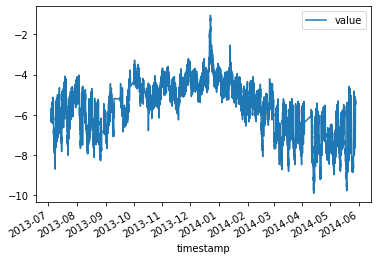

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Change from fahrenheit to Celcius
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp',y='value')

In [10]:
# Feature Engineering (07:00 to 22:00)
# the hours and if it's night or day
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours']<=22)).astype(int)

In [14]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
outliers_fraction = 0.01

In [15]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

C:\Users\conne\AppData\Local\Temp/ipykernel_3388/38874915.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)


In [20]:
df.head(15)

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,2013-07-04 00:00:00,-6.086162,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,-5.672769,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,-5.778455,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,-6.370556,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,-6.270509,4,0,3,1,13729104,2
5,2013-07-04 05:00:00,-6.030566,5,0,3,1,13729140,2
6,2013-07-04 06:00:00,-6.271678,6,0,3,1,13729176,2
7,2013-07-04 07:00:00,-6.243948,7,1,3,1,13729212,3
8,2013-07-04 08:00:00,-6.306570,8,1,3,1,13729248,3
9,2013-07-04 09:00:00,-6.362320,9,1,3,1,13729284,3


<Figure size 720x432 with 0 Axes>

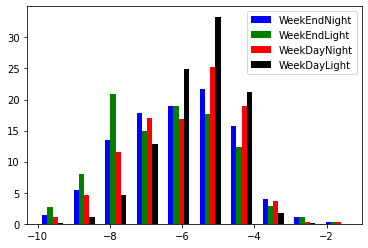

In [21]:
# creation of 4 distint categories that seem useful (week end/day & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0,'value']
b = df.loc[df['categories'] == 1,'value']
c = df.loc[df['categories'] == 2,'value']
d = df.loc[df['categories'] == 3,'value']

plt.figure(figsize=(10,6))
fig,ax = plt.subplots()
a_heights , a_bins = np.histogram(a)
b_heights , b_bins = np.histogram(b,bins=a_bins)
c_heights , c_bins = np.histogram(c,bins=a_bins)
d_heights , d_bins = np.histogram(d,bins=a_bins)

width = (a_bins[1]-a_bins[0])/6

ax.bar(a_bins[:-1],(a_heights*100/a.count()),width=width,facecolor='blue',label="WeekEndNight")
ax.bar(b_bins[:-1]+width,(b_heights*100/b.count()),width=width,facecolor='green',label="WeekEndLight")
ax.bar(a_bins[:-1]+width*2,(c_heights*100/c.count()),width=width,facecolor='red',label="WeekDayNight")
ax.bar(a_bins[:-1]+width*3,(d_heights*100/d.count()),width=width,facecolor='black',label="WeekDayLight")
plt.legend()
plt.show()

# Models

In [23]:
# Take usefull data and normalize them or standardize them
data = df[['value','hours','daylight','DayOfTheWeek','WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# Reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standarize these 2 features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [24]:
data.head()

,0,1
0,0.066191,1.755363
1,-0.009413,1.647609
2,-0.009359,1.577677
3,0.061592,1.543184
4,0.031660,1.458262


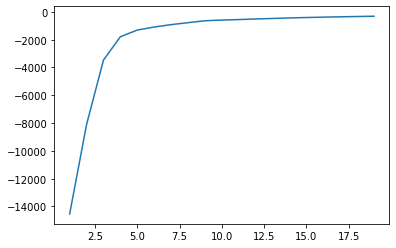

In [25]:
n_cluster = range(1,20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig,ax = plt.subplots()
ax.plot(n_cluster,scores)
plt.show()

In [26]:
# Randomly choosing 15 centriod for these data
df['cluster'] = kmeans[14].predict(data)
df['precipal_feature1'] = data[0]
df['precipal_feature2'] = data[1]
df['cluster'].value_counts()

9     712
11    651
1     632
14    615
13    587
0     585
4     578
7     533
5     432
3     358
8     350
6     349
10    339
2     308
12    238
Name: cluster, dtype: int64

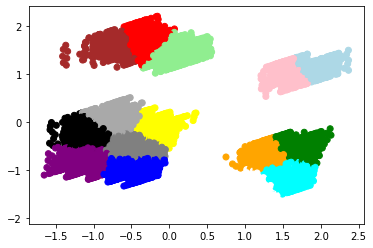

In [30]:
fig,ax = plt.subplots()
colors= {0:'red',1:'blue',2:'green',3:'pink',4:'black',5:'orange',6:'cyan',7:'yellow',8:'brown',9:'purple',10:'white',11:'grey',
        12:'lightblue',13:'lightgreen',14:'darkgrey'}
ax.scatter(df['precipal_feature1'],df['precipal_feature2'],c=df['cluster'].apply(lambda x:colors[x]))
plt.show()

In [36]:
# get the distance between each point and its nearest centriod. the biggest distance are considers as anamoly
distance = getDistanceByPoint(data,kmeans[14])
number_of_outliers = int(outliers_fraction* len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df['anamoly21'] = (distance >= threshold).astype(int)

C:\Users\conne\AppData\Local\Temp/ipykernel_3388/1442477583.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()


In [37]:
df.head(10)

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,cluster,precipal_feature1,precipal_feature2,anamoly21
0,2013-07-04 00:00:00,-6.086162,0,0,3,1,13728960,2,13,0.066191,1.755363,0
1,2013-07-04 01:00:00,-5.672769,1,0,3,1,13728996,2,13,-0.009413,1.647609,0
2,2013-07-04 02:00:00,-5.778455,2,0,3,1,13729032,2,13,-0.009359,1.577677,0
3,2013-07-04 03:00:00,-6.370556,3,0,3,1,13729068,2,13,0.061592,1.543184,0
4,2013-07-04 04:00:00,-6.270509,4,0,3,1,13729104,2,13,0.031660,1.458262,0
5,2013-07-04 05:00:00,-6.030566,5,0,3,1,13729140,2,13,-0.018663,1.363146,0
6,2013-07-04 06:00:00,-6.271678,6,0,3,1,13729176,2,13,0.001131,1.303081,0
7,2013-07-04 07:00:00,-6.243948,7,1,3,1,13729212,3,7,-0.220631,0.093570,0
8,2013-07-04 08:00:00,-6.306570,8,1,3,1,13729248,3,7,-0.226853,0.020499,0
9,2013-07-04 09:00:00,-6.362320,9,1,3,1,13729284,3,7,-0.234077,-0.053072,0


<AxesSubplot:>

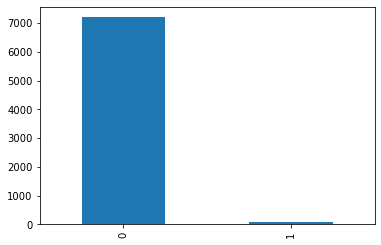

In [39]:
df['anamoly21'].value_counts().plot.bar()

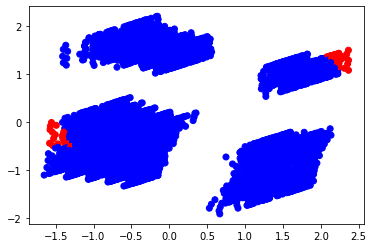

In [42]:
fig , ax = plt.subplots()
colors = {0:'blue',1:'red'}
ax.scatter(df['precipal_feature1'],df['precipal_feature2'],c=df['anamoly21'].apply(lambda x:colors[x]))
plt.show()

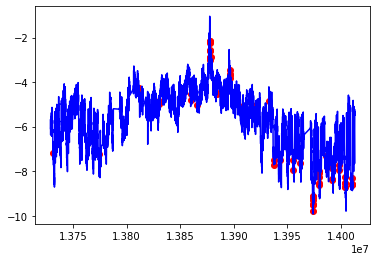

In [46]:
fig , ax = plt.subplots()
a = df.loc[df['anamoly21']==1,['time_epoch','value']]
ax.plot(df['time_epoch'],df['value'],color='blue')
ax.scatter(a['time_epoch'],a['value'],color='red')
plt.show()

# Isolation Forest

In [48]:
# Take usefull data and normalize them or standardize them
data = df[['value','hours','daylight','DayOfTheWeek','WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
model = IsolationForest(contamination=outliers_fraction)
model.fit(data)
# add data to the main
df['anamoly25'] = pd.Series(model.predict(data))
df['anamoly25'] = df['anamoly25'].map({1:0,-1:1})
print(df['anamoly25'].value_counts())

0    7194
1      73
Name: anamoly25, dtype: int64


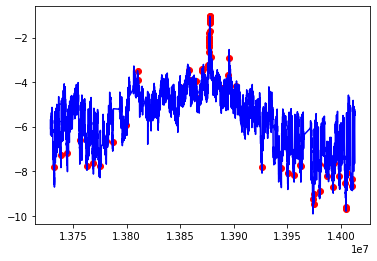

In [49]:
fig , ax = plt.subplots()
a = df.loc[df['anamoly25']==1,['time_epoch','value']]
ax.plot(df['time_epoch'],df['value'],color='blue')
ax.scatter(a['time_epoch'],a['value'],color='red')
plt.show()

# One class SVM

In [50]:
# Take usefull data and normalize them or standardize them
data = df[['value','hours','daylight','DayOfTheWeek','WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
model = OneClassSVM(nu=0.95*outliers_fraction)
data = pd.DataFrame(np_scaled)
model.fit(data)
# add data to the main
df['anamoly26'] = pd.Series(model.predict(data))
df['anamoly26'] = df['anamoly26'].map({1:0,-1:1})
print(df['anamoly26'].value_counts())

0    7198
1      69
Name: anamoly26, dtype: int64


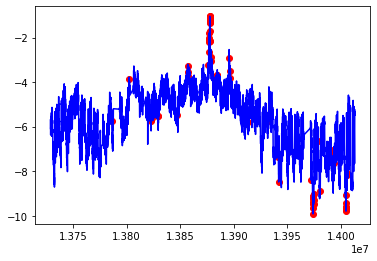

In [51]:
fig , ax = plt.subplots()
a = df.loc[df['anamoly26']==1,['time_epoch','value']]
ax.plot(df['time_epoch'],df['value'],color='blue')
ax.scatter(a['time_epoch'],a['value'],color='red')
plt.show()